# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

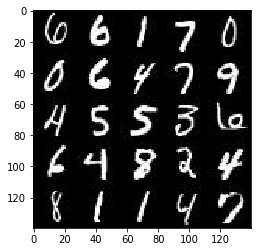

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

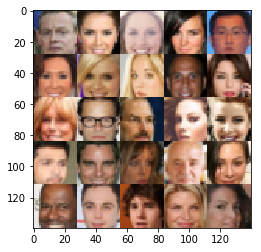

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests
import numpy as np

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32, [])
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [97]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Create alpha for leaky reLUs
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st Convolutional layer - Note: No batch normalization on 1st layer
        x1 = tf.layers.conv2d(images, 64, (5, 5), strides=2, padding='same', use_bias=False)
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=0.5, training=True)
        # Now h/2 x w/2 x 32
        
        # 2nd Convolutional layer
        x2 = tf.layers.conv2d(relu1, 128, (5, 5), strides=2, padding='same', use_bias=False)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.5, training=True)
        # Now h/4 x w/4 x 64
        
        # 3rd Convolutional layer
        x3 = tf.layers.conv2d(relu2, 256, (5, 5), strides=2, padding='same', use_bias=False)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.5, training=True)
        # Now h/8 x w/8 x 128
        
        # Store image height and width for use in flattening convolutional layer
        height = int(relu3.get_shape().as_list()[1])
        width = int(relu3.get_shape().as_list()[2])
    
        # Output layer
        flat = tf.reshape(relu3, (-1, height * width * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [98]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected layer and reshape for use by transpose convolutional layers
        x1 = tf.layers.dense(z, 3*3*512, use_bias=False)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.nn.relu(bn1)
        relu1 = tf.layers.dropout(relu1, rate=0.3, training=is_train)
        
        # 1st Transpose Convolutional layer
        x2 = tf.layers.conv2d_transpose(relu1, 256, (3, 3), strides=2, padding='valid', use_bias=False)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.nn.relu(bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.3, training=is_train)
        
        # 2nd Transpose Convolutional layer
        x3 = tf.layers.conv2d_transpose(relu2, 128, (5, 5), strides=2, padding='same', use_bias=False)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.nn.relu(bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.3, training=is_train)
    
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, (5, 5), strides=2, padding='same')
    return tf.nn.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [99]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Calculating outputs and logits of model
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                labels=tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [100]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get each agent's variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    g_vars = [var for var in t_vars if 'generator' in var.name]
    
    # Create optimizer for each agent
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [101]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [102]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Create the inputs
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Create the losses
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Create the optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_count = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Normalize images to have values between [-1, 1]
                batch_images = batch_images * 2
                
                # Get random noise for z_vector
                z_vector = np.random.uniform(low=-1, high=1, size=[batch_size, z_dim])
                
                # Run optimizers
                sess.run([d_opt, g_opt], feed_dict={input_real: batch_images,
                                           input_z: z_vector,
                                           learn_rate: learning_rate})
                
                # Run generator optimizer a 2nd time
                sess.run(g_opt, feed_dict={input_real: batch_images,
                                           input_z: z_vector,
                                           learn_rate: learning_rate})
                
                # Keep track of batch number
                batch_count += 1
                
                # Print out loss statistics every 25 batches
                if batch_count % 25 == 0:
                    d_batch_loss, g_batch_loss = sess.run([d_loss, g_loss], feed_dict={input_real: batch_images,
                                                         input_z: z_vector,
                                                         learn_rate: learning_rate})
                    print('Epoch({}/{}) - Discriminator Training Loss: {:.4f}  ' \
                    'Generator Training Loss: {:.4f}'.format(epoch_i + 1, epoch_count, d_batch_loss, g_batch_loss))
                
                # Print out generator output every 100 batches 
                if batch_count % 100 == 0:
                    num_images_to_show = 20
                    show_generator_output(sess, num_images_to_show, input_z, data_shape[3], data_image_mode)
                    
        # Print out generator output at the end of training 
        num_images_to_show_end = 20
        show_generator_output(sess, num_images_to_show_end, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch(1/2) - Discriminator Training Loss: 1.3790  Generator Training Loss: 1.2982
Epoch(1/2) - Discriminator Training Loss: 1.9910  Generator Training Loss: 0.9906
Epoch(1/2) - Discriminator Training Loss: 1.2770  Generator Training Loss: 2.0959
Epoch(1/2) - Discriminator Training Loss: 1.5918  Generator Training Loss: 0.6585


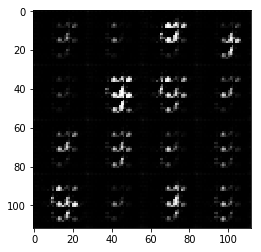

Epoch(1/2) - Discriminator Training Loss: 1.3981  Generator Training Loss: 0.9703
Epoch(1/2) - Discriminator Training Loss: 1.3153  Generator Training Loss: 0.8299
Epoch(1/2) - Discriminator Training Loss: 1.2827  Generator Training Loss: 1.0277
Epoch(1/2) - Discriminator Training Loss: 1.9543  Generator Training Loss: 0.8903


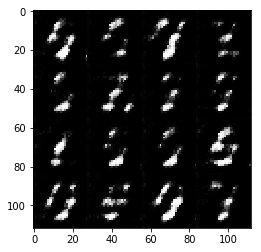

Epoch(1/2) - Discriminator Training Loss: 0.9953  Generator Training Loss: 1.2894
Epoch(1/2) - Discriminator Training Loss: 1.6342  Generator Training Loss: 0.6875
Epoch(1/2) - Discriminator Training Loss: 1.2916  Generator Training Loss: 1.1851
Epoch(1/2) - Discriminator Training Loss: 1.6031  Generator Training Loss: 1.0199


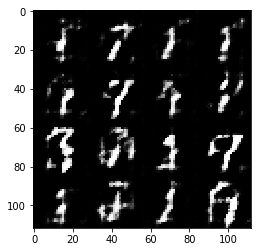

Epoch(1/2) - Discriminator Training Loss: 1.4437  Generator Training Loss: 0.6433
Epoch(1/2) - Discriminator Training Loss: 1.3554  Generator Training Loss: 0.7512
Epoch(1/2) - Discriminator Training Loss: 1.5103  Generator Training Loss: 0.8312
Epoch(1/2) - Discriminator Training Loss: 1.4890  Generator Training Loss: 0.7348


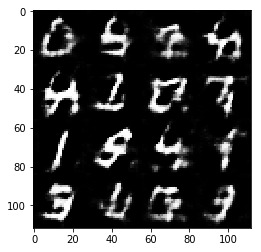

Epoch(1/2) - Discriminator Training Loss: 1.3358  Generator Training Loss: 0.7286
Epoch(1/2) - Discriminator Training Loss: 1.4352  Generator Training Loss: 0.7579
Epoch(2/2) - Discriminator Training Loss: 1.4062  Generator Training Loss: 0.7354
Epoch(2/2) - Discriminator Training Loss: 1.5130  Generator Training Loss: 0.5250
Epoch(2/2) - Discriminator Training Loss: 1.4101  Generator Training Loss: 1.0816
Epoch(2/2) - Discriminator Training Loss: 1.4459  Generator Training Loss: 0.5870


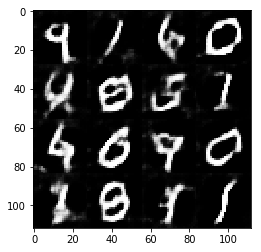

Epoch(2/2) - Discriminator Training Loss: 1.3507  Generator Training Loss: 0.6988
Epoch(2/2) - Discriminator Training Loss: 1.3771  Generator Training Loss: 0.7324
Epoch(2/2) - Discriminator Training Loss: 1.3609  Generator Training Loss: 0.7384
Epoch(2/2) - Discriminator Training Loss: 1.4926  Generator Training Loss: 0.5956


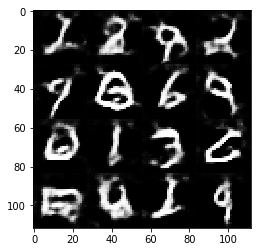

Epoch(2/2) - Discriminator Training Loss: 1.4114  Generator Training Loss: 0.9432
Epoch(2/2) - Discriminator Training Loss: 1.4989  Generator Training Loss: 0.7100
Epoch(2/2) - Discriminator Training Loss: 1.3808  Generator Training Loss: 0.6644
Epoch(2/2) - Discriminator Training Loss: 1.3432  Generator Training Loss: 0.8997


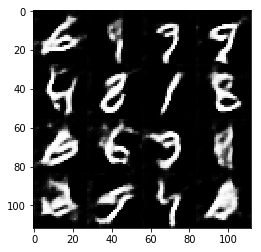

Epoch(2/2) - Discriminator Training Loss: 1.4317  Generator Training Loss: 0.7801
Epoch(2/2) - Discriminator Training Loss: 1.4660  Generator Training Loss: 0.9649
Epoch(2/2) - Discriminator Training Loss: 1.4211  Generator Training Loss: 0.6008
Epoch(2/2) - Discriminator Training Loss: 1.3831  Generator Training Loss: 0.8316


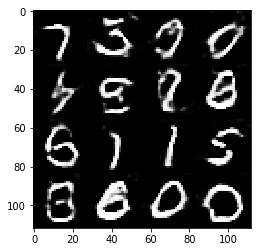

Epoch(2/2) - Discriminator Training Loss: 1.3634  Generator Training Loss: 1.0591
Epoch(2/2) - Discriminator Training Loss: 1.3386  Generator Training Loss: 0.6988


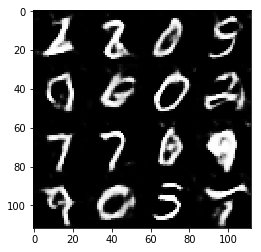

In [103]:
batch_size = 128
z_dim = 175
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch(1/1) - Discriminator Training Loss: 1.0403  Generator Training Loss: 1.8075
Epoch(1/1) - Discriminator Training Loss: 1.3205  Generator Training Loss: 1.2992
Epoch(1/1) - Discriminator Training Loss: 1.2275  Generator Training Loss: 1.6192
Epoch(1/1) - Discriminator Training Loss: 1.0673  Generator Training Loss: 1.9296


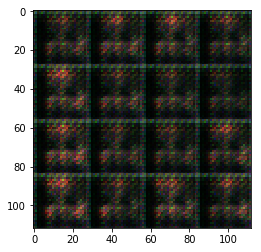

Epoch(1/1) - Discriminator Training Loss: 0.7701  Generator Training Loss: 2.0819
Epoch(1/1) - Discriminator Training Loss: 1.0040  Generator Training Loss: 1.3672
Epoch(1/1) - Discriminator Training Loss: 0.7311  Generator Training Loss: 2.3306
Epoch(1/1) - Discriminator Training Loss: 1.4322  Generator Training Loss: 1.9459


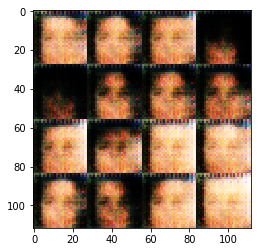

Epoch(1/1) - Discriminator Training Loss: 1.0827  Generator Training Loss: 1.4605
Epoch(1/1) - Discriminator Training Loss: 0.5602  Generator Training Loss: 2.5617
Epoch(1/1) - Discriminator Training Loss: 0.6588  Generator Training Loss: 2.1223
Epoch(1/1) - Discriminator Training Loss: 0.6992  Generator Training Loss: 2.1217


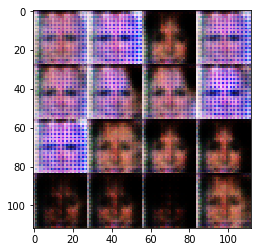

Epoch(1/1) - Discriminator Training Loss: 0.9153  Generator Training Loss: 1.9112
Epoch(1/1) - Discriminator Training Loss: 1.0139  Generator Training Loss: 1.8364
Epoch(1/1) - Discriminator Training Loss: 0.9273  Generator Training Loss: 3.2161
Epoch(1/1) - Discriminator Training Loss: 1.6962  Generator Training Loss: 0.8910


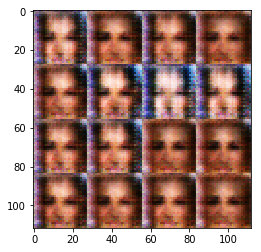

Epoch(1/1) - Discriminator Training Loss: 0.8986  Generator Training Loss: 1.9685
Epoch(1/1) - Discriminator Training Loss: 1.6545  Generator Training Loss: 1.1021
Epoch(1/1) - Discriminator Training Loss: 1.2574  Generator Training Loss: 1.2839
Epoch(1/1) - Discriminator Training Loss: 0.7438  Generator Training Loss: 2.1069


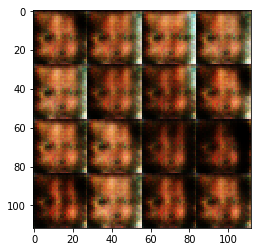

Epoch(1/1) - Discriminator Training Loss: 0.8362  Generator Training Loss: 1.5928
Epoch(1/1) - Discriminator Training Loss: 1.4370  Generator Training Loss: 0.8565
Epoch(1/1) - Discriminator Training Loss: 1.6189  Generator Training Loss: 0.8279
Epoch(1/1) - Discriminator Training Loss: 1.3855  Generator Training Loss: 1.0522


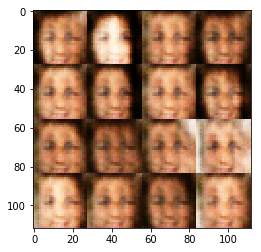

Epoch(1/1) - Discriminator Training Loss: 1.4107  Generator Training Loss: 1.0675
Epoch(1/1) - Discriminator Training Loss: 1.2208  Generator Training Loss: 1.3313
Epoch(1/1) - Discriminator Training Loss: 1.3393  Generator Training Loss: 1.4068
Epoch(1/1) - Discriminator Training Loss: 1.4830  Generator Training Loss: 1.0630


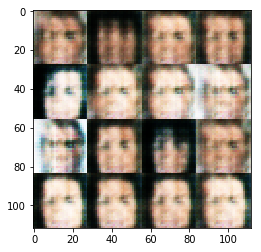

Epoch(1/1) - Discriminator Training Loss: 1.3350  Generator Training Loss: 1.2027
Epoch(1/1) - Discriminator Training Loss: 1.3958  Generator Training Loss: 1.2373
Epoch(1/1) - Discriminator Training Loss: 1.3827  Generator Training Loss: 1.0385
Epoch(1/1) - Discriminator Training Loss: 1.2091  Generator Training Loss: 1.0726


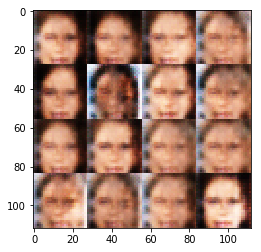

Epoch(1/1) - Discriminator Training Loss: 1.3924  Generator Training Loss: 1.1668
Epoch(1/1) - Discriminator Training Loss: 1.2999  Generator Training Loss: 1.0860
Epoch(1/1) - Discriminator Training Loss: 1.3494  Generator Training Loss: 1.0064
Epoch(1/1) - Discriminator Training Loss: 1.2616  Generator Training Loss: 1.0072


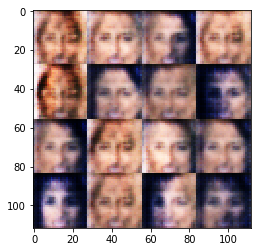

Epoch(1/1) - Discriminator Training Loss: 1.3054  Generator Training Loss: 1.1344
Epoch(1/1) - Discriminator Training Loss: 1.4793  Generator Training Loss: 0.8650
Epoch(1/1) - Discriminator Training Loss: 1.3808  Generator Training Loss: 0.9293
Epoch(1/1) - Discriminator Training Loss: 1.4177  Generator Training Loss: 0.9644


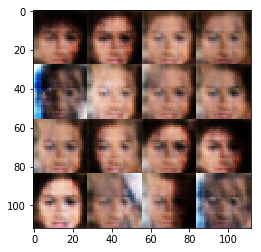

Epoch(1/1) - Discriminator Training Loss: 1.2916  Generator Training Loss: 1.0525
Epoch(1/1) - Discriminator Training Loss: 1.2259  Generator Training Loss: 1.1268
Epoch(1/1) - Discriminator Training Loss: 1.2125  Generator Training Loss: 1.0864
Epoch(1/1) - Discriminator Training Loss: 1.2720  Generator Training Loss: 1.0293


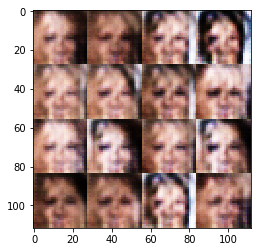

Epoch(1/1) - Discriminator Training Loss: 1.1893  Generator Training Loss: 0.9633
Epoch(1/1) - Discriminator Training Loss: 1.4398  Generator Training Loss: 0.8942
Epoch(1/1) - Discriminator Training Loss: 1.4170  Generator Training Loss: 0.9035
Epoch(1/1) - Discriminator Training Loss: 1.5041  Generator Training Loss: 0.7569


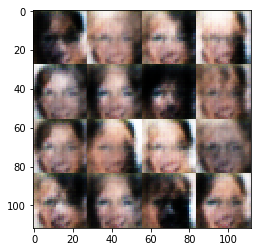

Epoch(1/1) - Discriminator Training Loss: 1.2389  Generator Training Loss: 1.0440
Epoch(1/1) - Discriminator Training Loss: 1.4121  Generator Training Loss: 0.9785
Epoch(1/1) - Discriminator Training Loss: 1.3153  Generator Training Loss: 0.9515
Epoch(1/1) - Discriminator Training Loss: 1.4219  Generator Training Loss: 0.8201


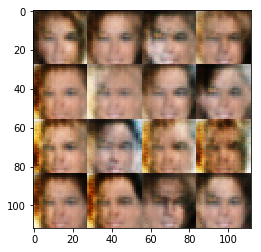

Epoch(1/1) - Discriminator Training Loss: 1.3379  Generator Training Loss: 0.9150
Epoch(1/1) - Discriminator Training Loss: 1.4838  Generator Training Loss: 0.7555
Epoch(1/1) - Discriminator Training Loss: 1.5843  Generator Training Loss: 0.7709
Epoch(1/1) - Discriminator Training Loss: 1.3135  Generator Training Loss: 1.0315


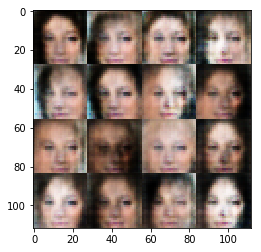

Epoch(1/1) - Discriminator Training Loss: 1.3836  Generator Training Loss: 0.8932
Epoch(1/1) - Discriminator Training Loss: 1.5937  Generator Training Loss: 0.8391
Epoch(1/1) - Discriminator Training Loss: 1.3737  Generator Training Loss: 0.8755
Epoch(1/1) - Discriminator Training Loss: 1.4450  Generator Training Loss: 0.7629


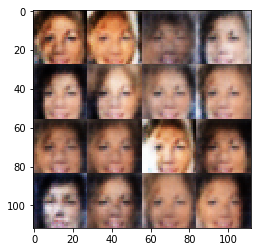

Epoch(1/1) - Discriminator Training Loss: 1.4878  Generator Training Loss: 0.8167
Epoch(1/1) - Discriminator Training Loss: 1.2879  Generator Training Loss: 0.9809
Epoch(1/1) - Discriminator Training Loss: 1.4899  Generator Training Loss: 0.7663


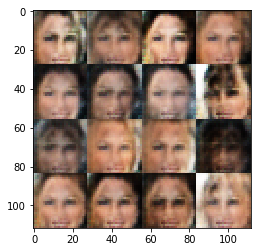

In [105]:
batch_size = 128
z_dim = 175
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.